From Rxx, and Gideon, I learned about this applied SME signal boosting on quadradic funding. 

It means that the quadradic funding algorithm is weighted heavier from donors that qualify as SME.

Congrats to the TEC coordination team for pulling this off. They pulled this off on round 1.

Let's apply engineering to this process.

Engineering is about the production of artifacts in a safe and ethical way. 

Artifacts have interfaces that people may use. Engineering allows the usage of interfaces without bad things happening.



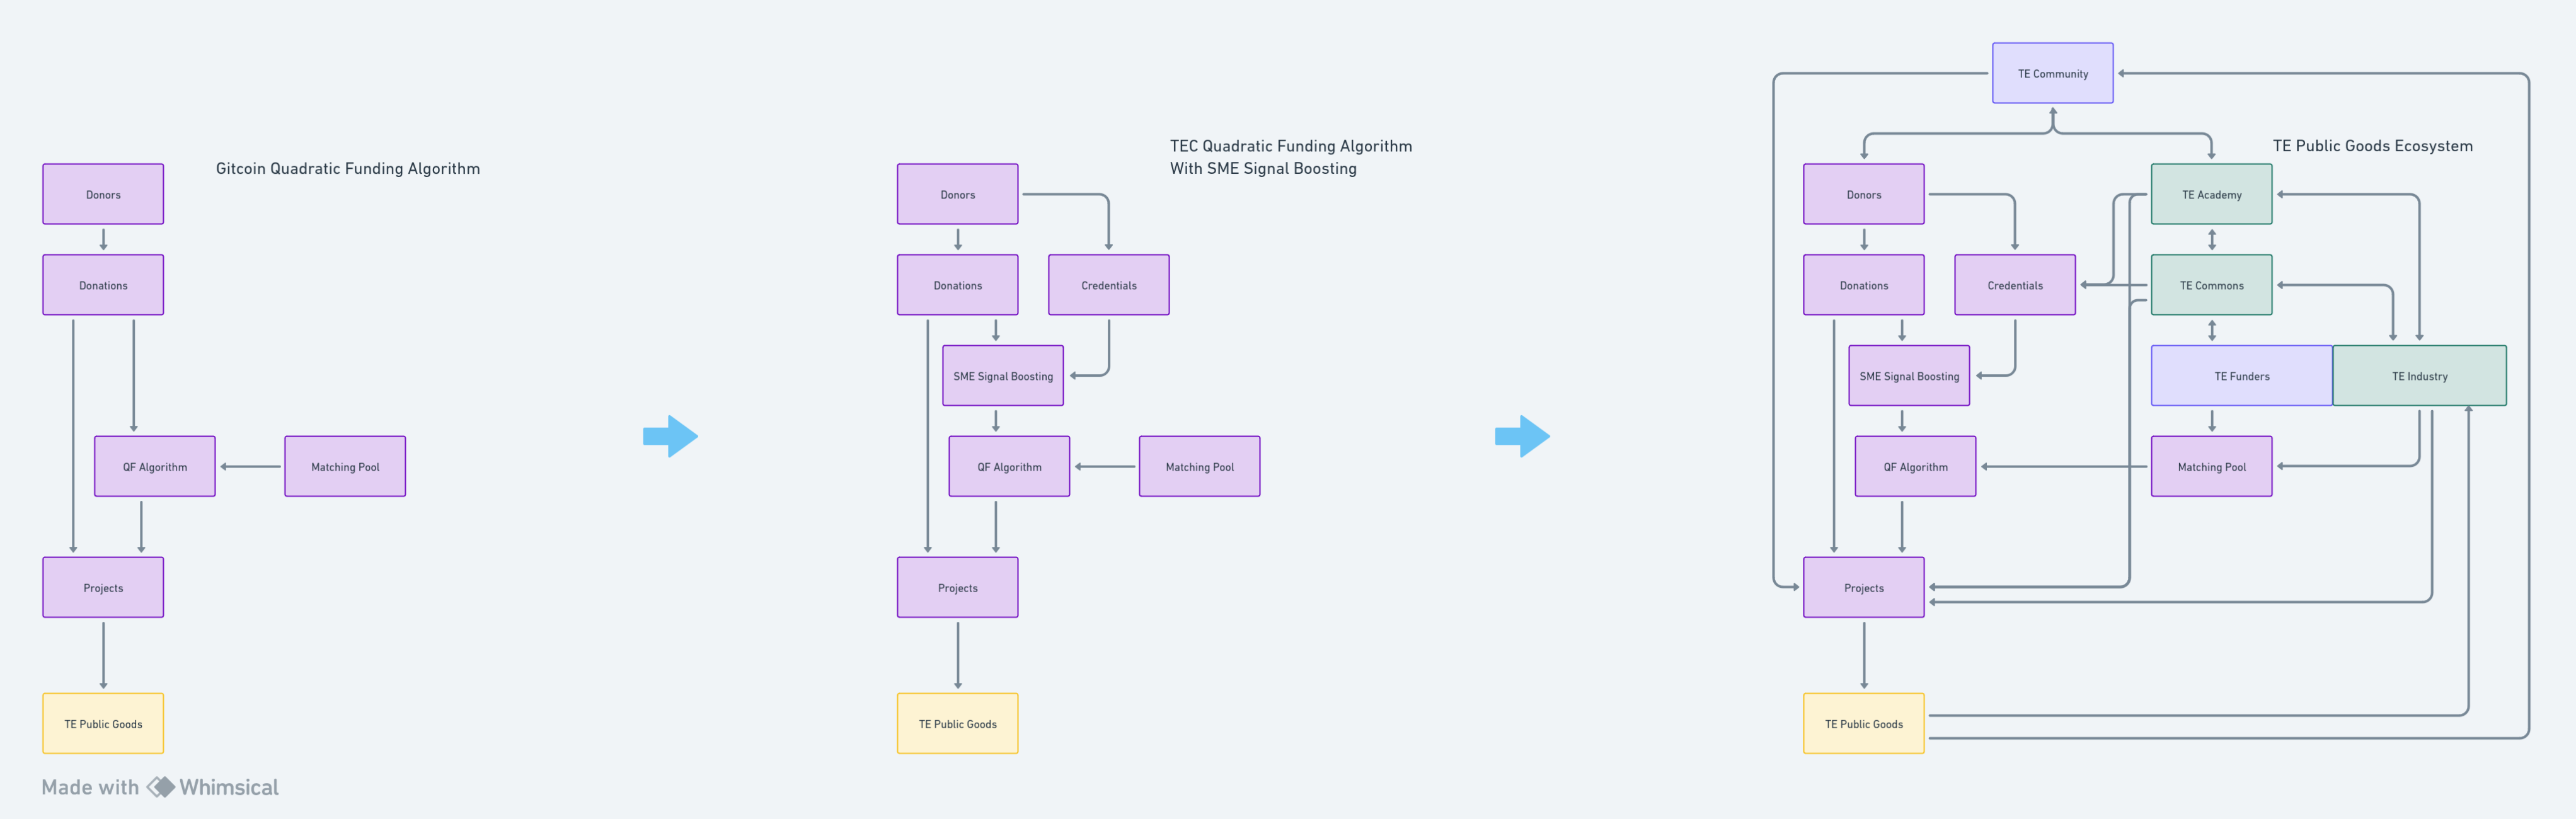![image.png]()

Link to the above board: https://whimsical.com/original-qfsme-mechanism-flowchart-QjXRdbkFmBcXBhnV175K9z 

Resources


* https://arxiv.org/pdf/2010.01193.pdf
* https://arxiv.org/pdf/1809.06421.pdf
* https://vitalik.ca/general/2019/12/07/quadratic.html
* https://qf.gitcoin.co/?grant=&grant=&grant=&match=1000
* https://medium.com/token-engineering-commons/expertise-and-quadratic-funding-bd4f0c5c3e23 

## A Flexible Design for Funding Public Goods

https://arxiv.org/pdf/1809.06421.pdf

### 3.0 Model

In [1]:
import numpy as np

# Number of Citizens in the Society
N = 30

# Society is a set of citizens
society = set(range(N))

# Community is a random subset of the society. The community size is from 1 up to 1/2 of the society.
community = np.random.choice(a=list(society), size=np.random.randint(1, len(society)/2), replace=False, p=None)

# Public Goods are proposed by community members. Cardinality is from 1 up to 1/2 size of the community.
public_goods = list(enumerate(np.random.choice(a=list(community), size=np.random.randint(1, len(community)/2), replace=True, p=None)))

In [2]:
community

array([11, 12, 13,  0, 18, 17, 19, 28,  2])

In [3]:
public_goods

[(0, 18), (1, 18)]

In [4]:
len(society)

30

In [5]:
len(community)

9

In [6]:
len(public_goods)

2

### 3.1 Individual Preferences and Actions

In [7]:
import param as pm

class Value(pm.Parameterized):
    citizen_i = pm.Integer()
    public_good_p = pm.Tuple()
    value_map = pm.DataFrame(columns=['citizen', 'public_good', 'value'])
    value_functions = []
    
    def F(self, x):
        return x
    
    def currency_utility(funding_p: float) -> float:
        return self.__getattr__['F'](funding_p)

In [8]:
class Value(pm.Parameterized):
    funding = pm.Magnitude()

### 3.1 Side Quest: Generating Value Functions - Continued

In [9]:
import param
import numpy as np
import pandas as pd
import hvplot.pandas
import panel as pn

class CurveGenerator(param.Parameterized):
    f0 = param.Number(default=0.2, bounds=(0, 1), doc="Value of f(0)")
    f1 = param.Number(default=0.8, bounds=(0, 1), doc="Value of f(1)")
    initial_slope = param.Number(default=1, bounds=(-5, 5), doc="Initial slope of the curve")
    exponent = param.Number(default=1, bounds=(1, 5), doc="Exponent of the curve")
    num_oscillations = param.Integer(default=1, bounds=(0, 5), doc="Number of oscillations/peaks in the curve")
    
    def x(self):
        return np.linspace(0, 1, 400)
    
    def f(self, x):
        epsilon = 1e-10
        b = self.f0
        a = self.initial_slope / (self.exponent * (b + epsilon)**(self.exponent-1))
        c = (self.f1 - self.f0 - a) / 2
        d = self.num_oscillations
        y = a*x**self.exponent + b + c*np.sin(d*np.pi*x)
        
        # Scale and shift the curve to ensure it starts at f0 and ends at f1
        y = self.f0 + (self.f1 - self.f0) * (y - y.min()) / (y.max() - y.min())
        return y
    
    @param.depends('f0', 'f1', 'initial_slope', 'exponent', 'num_oscillations')
    def view(self):
        x = self.x()
        y = self.f(x)
        df = pd.DataFrame({'x': x, 'y': y})
        return df.hvplot.line(x='x', y='y', ylim=(0, 1.01), width=500, height=400)

class SigmoidGenerator(param.Parameterized):
    f0 = param.Number(default=0.5, bounds=(0, 1), doc="Value of the function at x=0")
    f1 = param.Number(default=0.5, bounds=(0, 1), doc="Value of the function at x=1")
    initial_slope = param.Number(default=1, bounds=(-5, 5), doc="Initial slope of the curve")
    exponent = param.Number(default=0.3, bounds=(0.1, 0.5), doc="Exponent of the curve")
    oscillations = param.Integer(default=1, bounds=(1, 5), doc="Number of oscillations/peaks in the curve")
    
    def x(self):
        return np.linspace(0, 1, 400)
    
    def f(self, x):
        y = self.f0 + (self.f1 - self.f0) / (1 + np.exp(-self.initial_slope * (x - 0.5) * 10))**self.exponent
        y = y + 0.1 * np.sin(self.oscillations * np.pi * x)
        
        # Clip y values to ensure they stay within [0, 1]
        y = np.clip(y, 0, 1)
        return y
    
    @param.depends('f0', 'f1', 'initial_slope', 'exponent', 'oscillations')
    def view(self):
        x = self.x()
        y = self.f(x)
        df = pd.DataFrame({'x': x, 'y': y})
        return df.hvplot.line(x='x', y='y', ylim=(-0.01, 1.01))

class PowerFunctionGenerator(param.Parameterized):
    f0 = param.Number(default=0.1, bounds=(0, 1), doc="Value of the function at x=0")
    f1 = param.Number(default=0.5, bounds=(0, 1), doc="Value of the function at x=1")
    exponent_param = param.Number(default=0.5, bounds=(0.1, 2), doc="Parameter determining the exponent and slope")
    
    def x(self):
        return np.linspace(0.001, 1, 400)  # Start from 0.001 to avoid division by zero
    
    def f(self, x):
        epsilon = 1e-10
        b = 2 * self.exponent_param  # This maps [0, 1] to [0, 2] for the exponent
        a = self.f0
        c = (self.f1 - self.f0) / (1 ** b - 0 ** b + epsilon)
        y = a + c * x ** b
        
        # Clip y values to ensure they stay within [0, 1]
        y = np.clip(y, 0, 1)
        return y
    
    @param.depends('f0', 'f1', 'exponent_param')
    def view(self):
        x = self.x()
        y = self.f(x)
        df = pd.DataFrame({'x': x, 'y': y})
        return df.hvplot.line(x='x', y='y', ylim=(0, 1.01))


%opts magic unavailable (pyparsing cannot be imported)
%compositor magic unavailable (pyparsing cannot be imported)


In [10]:
import numbergen as ng
import numpy as np


# For CurveGenerator
def polynomial_curve_generator_params():
    return dict(
        f0=ng.UniformRandom(lbound=0, ubound=0.5, seed=None)(),
        f1=ng.UniformRandom(lbound=0, ubound=1)(),
        initial_slope=ng.UniformRandom(lbound=-5, ubound=5)(),
        exponent=ng.UniformRandom(lbound=1, ubound=5)(),
        num_oscillations=int(ng.UniformRandom(lbound=0, ubound=5)())
    )

# For SigmoidGenerator
def sigmoid_curve_generator_params():
    return dict(
        f0=ng.UniformRandom(lbound=0, ubound=0.5)(),
        f1=ng.UniformRandom(lbound=0, ubound=1)(),
        initial_slope=ng.UniformRandom(lbound=-5, ubound=5)(),
        exponent=ng.UniformRandom(lbound=0.1, ubound=0.5)(),
        oscillations=int(ng.UniformRandom(lbound=1, ubound=5)())
    )

# For PowerFunctionGenerator
def power_curve_generator_params():
    return dict(
        f0=ng.UniformRandom(lbound=0, ubound=0.5)(),
        f1=ng.UniformRandom(lbound=0, ubound=1)(),
        exponent_param=ng.UniformRandom(lbound=0.1, ubound=2)()
)



# Now, you can use these dictionaries to create instances of your classes as you've done in your code.
value_function_generators = np.array([
    (CurveGenerator, polynomial_curve_generator_params),
    (SigmoidGenerator, sigmoid_curve_generator_params),
    (PowerFunctionGenerator, power_curve_generator_params),
])

# Use numpy's advanced indexing to obtain the selected_generators
value_function_samples= value_function_generators[np.random.choice(len(value_function_generators), size=len(public_goods)*len(society))]

# Instantiate utility curves using python param and numbergen
value_functions = [Generator(**params()) for Generator, params in value_function_samples]

In [11]:
df_value_functions = pd.DataFrame([s.f(s.x()) for s in value_functions]).T
df_value_functions.columns = [(p, i) for p in public_goods for i in society]
df_value_functions.columns.name = "value_p_i"
df_value_functions.index = np.linspace(0,1,len(df_value_functions))
df_value_functions.index.name = "funding"

In [12]:
df_value_functions

value_p_i,"((0, 18), 0)","((0, 18), 1)","((0, 18), 2)","((0, 18), 3)","((0, 18), 4)","((0, 18), 5)","((0, 18), 6)","((0, 18), 7)","((0, 18), 8)","((0, 18), 9)",...,"((1, 18), 20)","((1, 18), 21)","((1, 18), 22)","((1, 18), 23)","((1, 18), 24)","((1, 18), 25)","((1, 18), 26)","((1, 18), 27)","((1, 18), 28)","((1, 18), 29)"
funding,,,,,,,,,,,,,,,,,,,,,
0.000000,0.333099,0.583452,0.442905,0.492520,0.346180,0.253905,0.250890,0.217737,0.561897,0.100243,...,0.215394,0.674799,0.377346,0.329098,0.410306,0.340810,0.456218,0.077049,0.443173,0.307566
0.002506,0.333099,0.586351,0.443864,0.492518,0.346190,0.257132,0.254394,0.220099,0.556592,0.100249,...,0.215394,0.676628,0.376874,0.331448,0.410307,0.341684,0.457005,0.076333,0.437685,0.307663
0.005013,0.333099,0.589249,0.444822,0.492511,0.346206,0.260358,0.257901,0.222459,0.551292,0.100259,...,0.215394,0.678456,0.376407,0.333797,0.410310,0.342557,0.457793,0.075618,0.432200,0.307798
0.007519,0.333099,0.592146,0.445777,0.492499,0.346225,0.263579,0.261407,0.224817,0.546002,0.100272,...,0.215394,0.680283,0.375946,0.336142,0.410314,0.343431,0.458580,0.074903,0.426721,0.307959
0.010025,0.333099,0.595041,0.446730,0.492483,0.346248,0.266796,0.264911,0.227171,0.540728,0.100288,...,0.215394,0.682109,0.375487,0.338484,0.410321,0.344304,0.459367,0.074190,0.421251,0.308142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.989975,0.923699,0.221778,0.381591,0.184186,0.406184,0.021828,0.832410,0.056018,0.911764,0.197465,...,0.726437,0.254851,0.416452,0.263450,0.742105,0.151671,0.310513,0.132653,0.876968,0.663401
0.992481,0.928745,0.220352,0.381857,0.182649,0.406412,0.016795,0.835540,0.053518,0.910287,0.197884,...,0.731341,0.250263,0.417077,0.260881,0.743973,0.148881,0.309721,0.133896,0.887348,0.664681
0.994987,0.933821,0.218886,0.382120,0.181109,0.406640,0.011748,0.838680,0.051015,0.908828,0.198305,...,0.736278,0.245665,0.417704,0.258309,0.745847,0.146076,0.308929,0.135145,0.897778,0.665962


In [13]:
df_value_functions.hvplot.line(x='funding', color='blue', alpha=0.2, line_width=5)

:NdOverlay   [value_p_i]
   :Curve   [funding]   (value)

In [14]:
 df_value_functions.melt(ignore_index=False)

,value_p_i,value
funding,,
0.000000,"((0, 18), 0)",0.333099
0.002506,"((0, 18), 0)",0.333099
0.005013,"((0, 18), 0)",0.333099
0.007519,"((0, 18), 0)",0.333099
0.010025,"((0, 18), 0)",0.333099
...,...,...
0.989975,"((1, 18), 29)",0.663401
0.992481,"((1, 18), 29)",0.664681
0.994987,"((1, 18), 29)",0.665962


In [15]:
df_value_functions_melted = df_value_functions.melt(ignore_index=False)
df_value_functions_melted

,value_p_i,value
funding,,
0.000000,"((0, 18), 0)",0.333099
0.002506,"((0, 18), 0)",0.333099
0.005013,"((0, 18), 0)",0.333099
0.007519,"((0, 18), 0)",0.333099
0.010025,"((0, 18), 0)",0.333099
...,...,...
0.989975,"((1, 18), 29)",0.663401
0.992481,"((1, 18), 29)",0.664681
0.994987,"((1, 18), 29)",0.665962


In [16]:
df_value_functions_melted['public_good'] = df_value_functions_melted['value_p_i'].astype(str).apply(eval).apply(lambda x: x[0]).astype(str)
df_value_functions_melted['citizen'] = df_value_functions_melted['value_p_i'].astype(str).apply(eval).apply(lambda x: x[1]).astype(str)

In [17]:
df_value_functions_melted

,value_p_i,value,public_good,citizen
funding,,,,
0.000000,"((0, 18), 0)",0.333099,"(0, 18)",0
0.002506,"((0, 18), 0)",0.333099,"(0, 18)",0
0.005013,"((0, 18), 0)",0.333099,"(0, 18)",0
0.007519,"((0, 18), 0)",0.333099,"(0, 18)",0
0.010025,"((0, 18), 0)",0.333099,"(0, 18)",0
...,...,...,...,...
0.989975,"((1, 18), 29)",0.663401,"(1, 18)",29
0.992481,"((1, 18), 29)",0.664681,"(1, 18)",29
0.994987,"((1, 18), 29)",0.665962,"(1, 18)",29


In [18]:
import hvplot.pandas

In [19]:
df_value_functions_melted.hvplot.scatter(y='value', by='public_good', alpha=0.1)

:NdOverlay   [public_good]
   :Scatter   [funding]   (value)

In [20]:
mean_utility_df = df_value_functions_melted.groupby(['funding', 'public_good'])[['value']].mean().reset_index()

In [21]:
mean_utility_df.hvplot.scatter(y='value', by='public_good')

:NdOverlay   [public_good]
   :Scatter   [index]   (value)

In [22]:
mean_utility_df

,funding,public_good,value
0,0.000000,"(0, 18)",0.290881
1,0.000000,"(1, 18)",0.343441
2,0.002506,"(0, 18)",0.291155
3,0.002506,"(1, 18)",0.343788
4,0.005013,"(0, 18)",0.291436
...,...,...,...
795,0.994987,"(1, 18)",0.362046
796,0.997494,"(0, 18)",0.363618
797,0.997494,"(1, 18)",0.362743
798,1.000000,"(0, 18)",0.363899
